(example_01_optical_flow_torus)=

# Extended Torus Model

In this tutorial, we apply the `circle_bundles` pipeline to confirm a 3-manifold model proposed in [] for high-contrast optical flow patches sampled from the Sintel dataset []. The model is homotopy equivalent to a torus, but the topology cannot be satsfactorally detected from a direct persistence computation. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ripser import ripser
from persim import plot_diagrams

import circle_bundles as cb

First, get a large sample of optical patches from the Sintel dataset:

In [2]:
import pickle 
import pandas as pd

patches_per_frame = 400
folder_path = ".../MPI-Sintel-complete/training/flow"   #path to Sintel flow frames

patch_df, file_paths = cb.get_patch_sample(
    folder_path,
    patches_per_frame = patches_per_frame,
    d = 3)

print('')
print(f'{len(patch_df)} optical flow patches sampled')

#Downsample if necessary
max_samples = 400000
if len(patch_df) > max_samples:
    patch_df = patch_df.sample(n=max_samples)


Finalizing dataframe... Done

416400 optical flow patches sampled


Next, preprocess the data -- compute contrast norms and keep only patches with contrast norm in the top 20%.  Then, use a KNN density estimator to measure the density of dataset near each datapoint:

In [3]:
hc_frac = 0.2
max_samples = 50000
k = [300]

patch_df = cb.preprocess_flow_patches(
    patch_df,
    hc_frac = hc_frac,
    max_samples = max_samples,
    k_list = k)


Finally, keep only the top 50% of patches by density value:

In [4]:
p = 0.5 
n_samples = int(p*len(patch_df))
data = np.vstack(patch_df['patch'])[:n_samples]    #Data is already sorted in decreasing order by density
print(f'Downsampled to {len(data)} patches')

Downsampled to 25000 patches


Compute a persistence diagram from a sample of the dataset.  If the dataset is truly concentrated around the proposed torus model, we would expect to see two 1-dimensional persistent classes and a persistent class in dimension 2: 

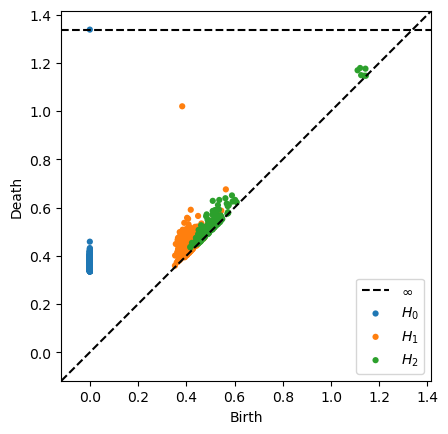

In [11]:
diagrams = ripser(data, maxdim = 2, n_perm = 500)['dgms']
plot_diagrams(diagrams, show=True)    

Observe that we see a single 1-dimensional persistent class and no persistent classes in dimension 2.  

Proceed with local-to-global analysis.  Compute the predominant flow axis in $\mathbb{RP}^{1}$ (as introduced by Adams et al.) and directionality (as introduced in ---) for each patch, and construct a cover of $\mathbb{RP}^{1}$.  

### Cover And Nerve Summary
- $n_\text{sets} = 16$, $n_\text{samples} = 25000$

**Recorded Simplex Counts:**

- $\#(\text{0-simplices}) = 16$
- $\#(\text{1-simplices}) = 16$
- *No recorded simplices in dimensions* $\ge 2$

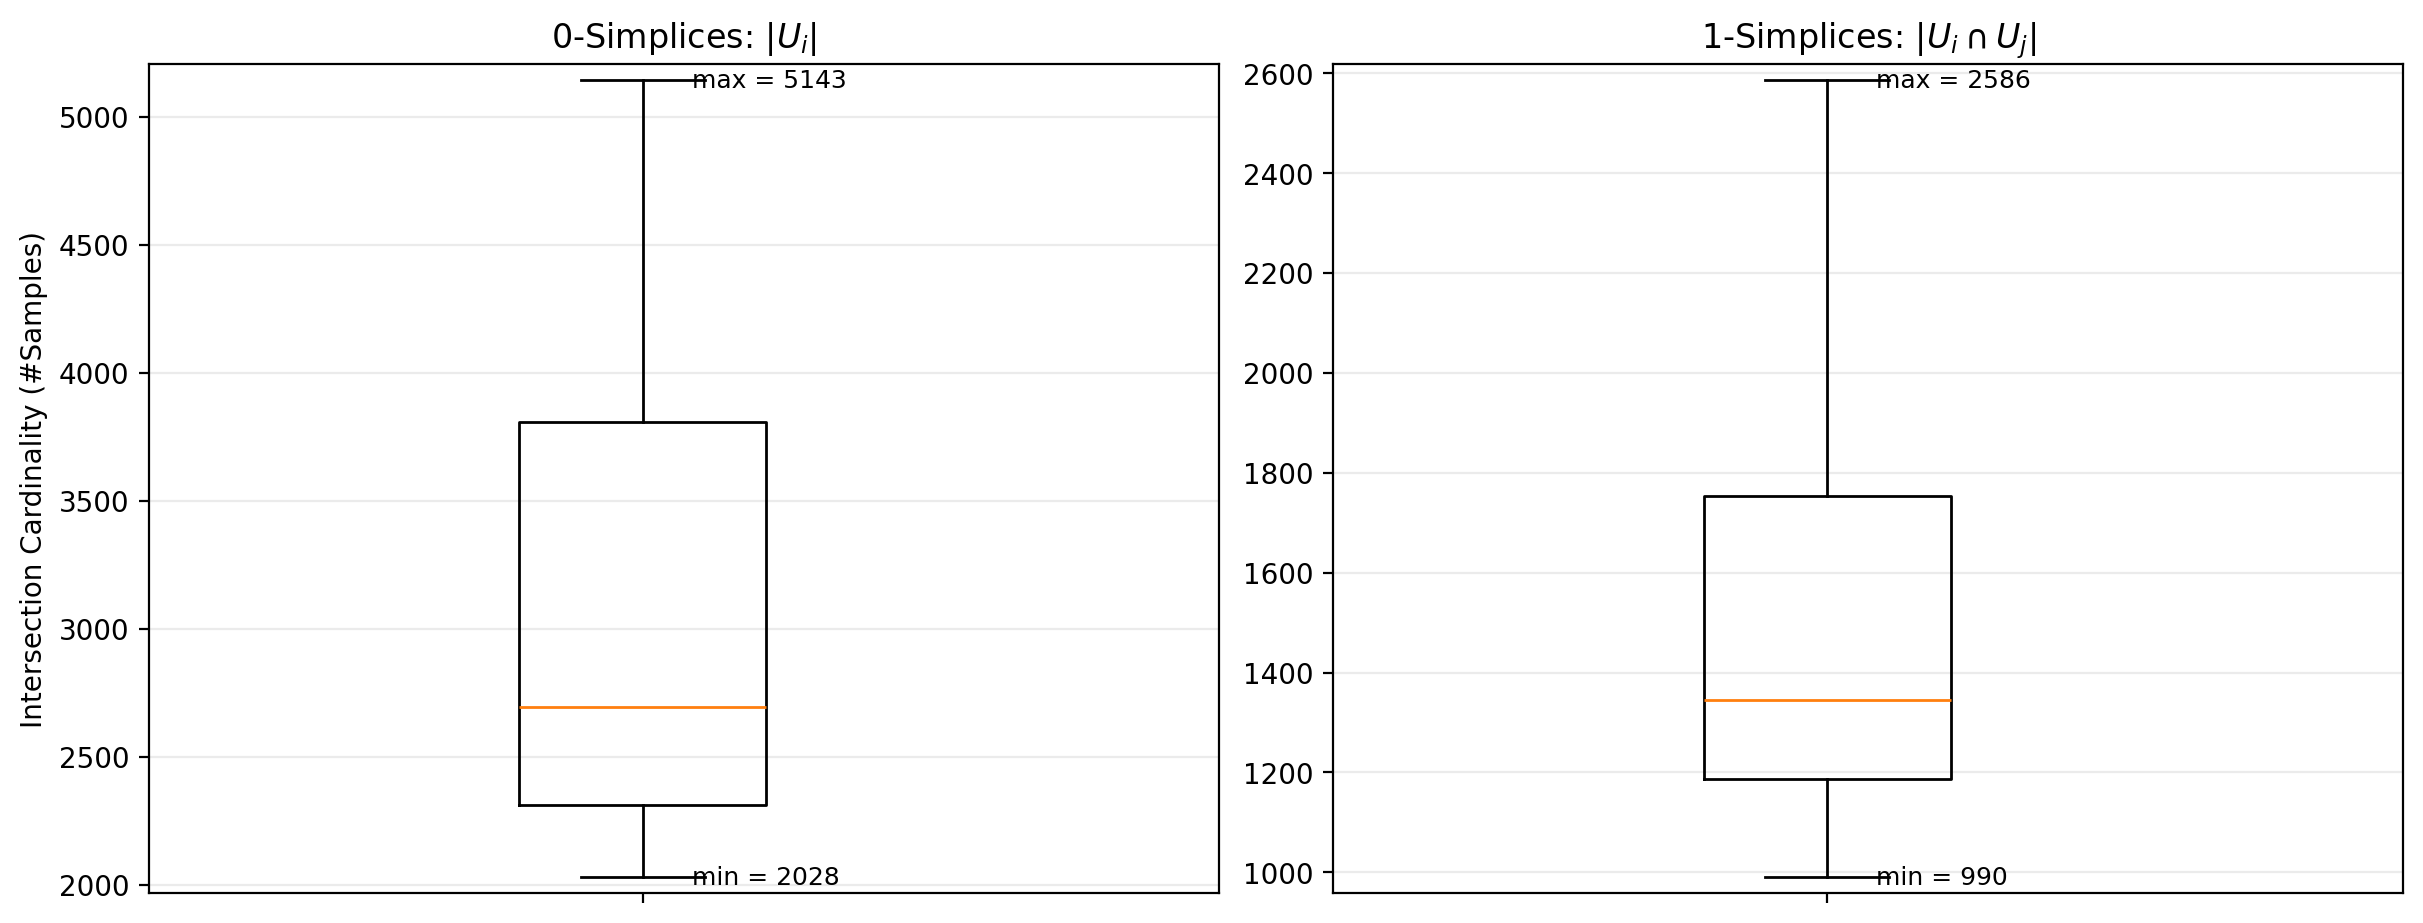

In [5]:
predom_dirs, ratios = cb.get_predominant_dirs(data)  

#Construct a cover of the base space
n_landmarks = 16
landmarks = np.linspace(0, np.pi, n_landmarks, endpoint= False).reshape(-1,1)
overlap = 1.99
radius = overlap* np.pi/(2*n_landmarks)

cover = cb.get_metric_ball_cover(
    predom_dirs.reshape(-1,1),
    landmarks,
    radius = radius,
    metric = cb.RP1AngleMetric()
)

bundle = cb.Bundle(X = data, cover = cover, show_summary = True)

View a sample of the dataset arranged by predominant flow direction:

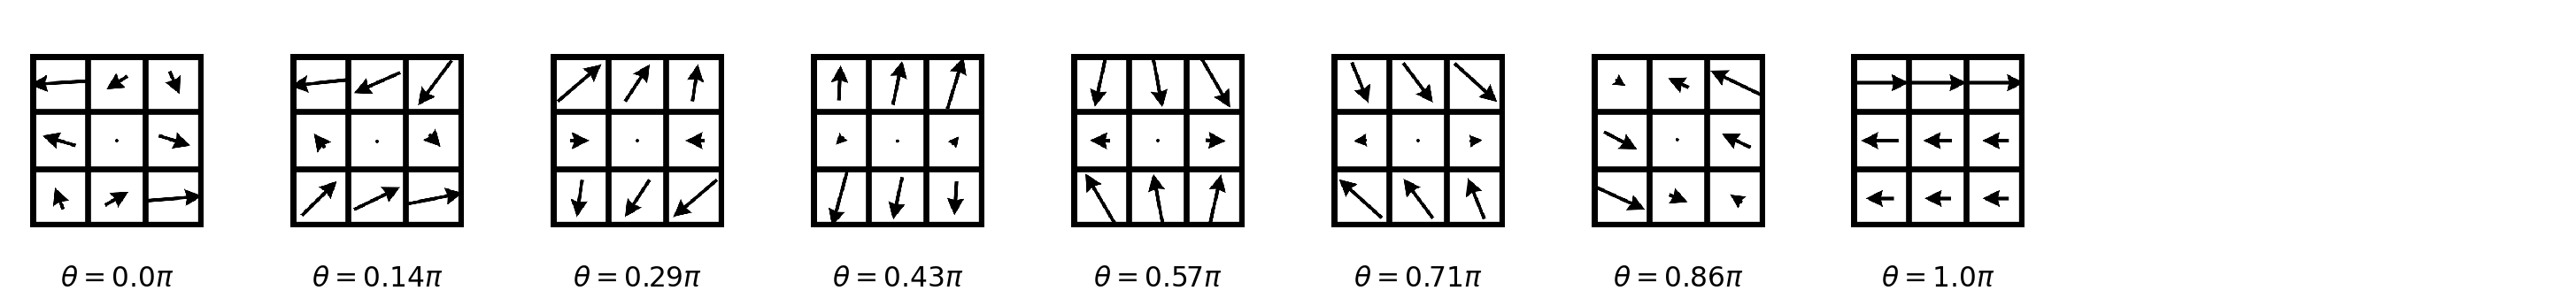

In [6]:
patch_vis = cb.make_patch_visualizer()

n_samples = 8

label_func = [fr"$\theta = {np.round(pred/np.pi, 2)}$" + r"$\pi$" for pred in predom_dirs]
fig = cb.show_data_vis(
    data, 
    patch_vis, 
    label_func = label_func, 
    angles = predom_dirs, 
    sampling_method = 'angle', 
    max_samples = n_samples)
plt.show()


Compute a persistence diagram for the data in each set $\pi^{-1}(U_{j})$:

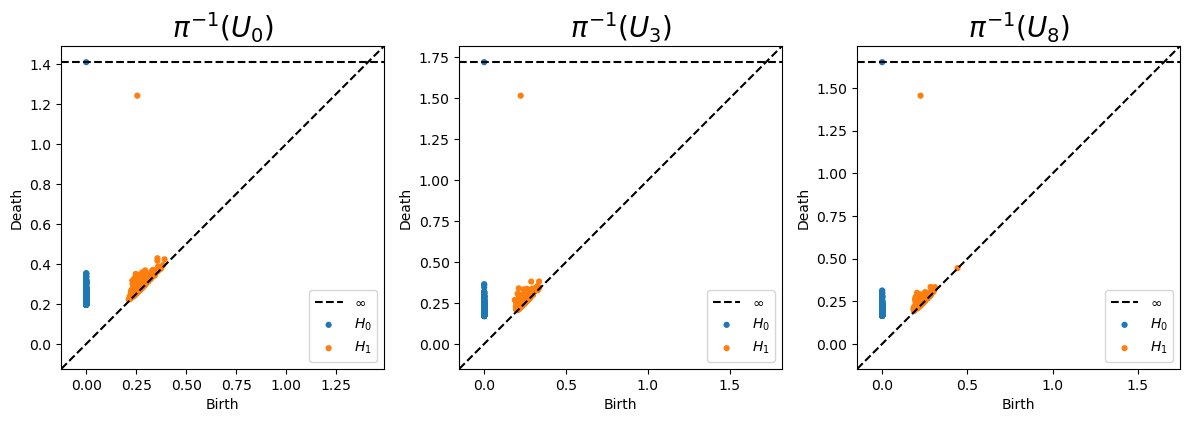

In [15]:
fiber_ids, dense_idx_list, rips_list = cb.get_local_rips(
    data,
    cover.U,
    p_values=None,
    to_view = [0,3,8], #Choose a few diagrams to compute 
                       #(or compute all by setting to None)
    maxdim=1,
    n_perm=500,
    random_state=None,
)

fig, axes = cb.plot_local_rips(
    fiber_ids,
    rips_list,
    n_cols=3,
    titles='default',
    font_size=20,
)

Observe that each $\pi^{-1}(U_{j})$ has a single 1-dimensional (circular) persistent feature, supporting the hypothesis that the data has the structure of a discrete approximate circle bundle over $\mathbb{RP}^{1}$. Up to isormorphism, there are two possible global structures for a circle bundle over $\mathbb{RP}^{1}\cong\mathbb{S}^{1}$, namely the torus (trivial) and the Klein bottle (non-orientable). These two possibilities are distinguished by the orientation class $w_{1}$.

Now, construct local circular coordinates, compute approximate transition matrices and characteristic classes:

In [7]:
local_triv_result = bundle.get_local_trivs(show_summary = True)
class_result = bundle.get_classes(show_summary = True)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

View the correlations between local circular coordinates on overlaps:

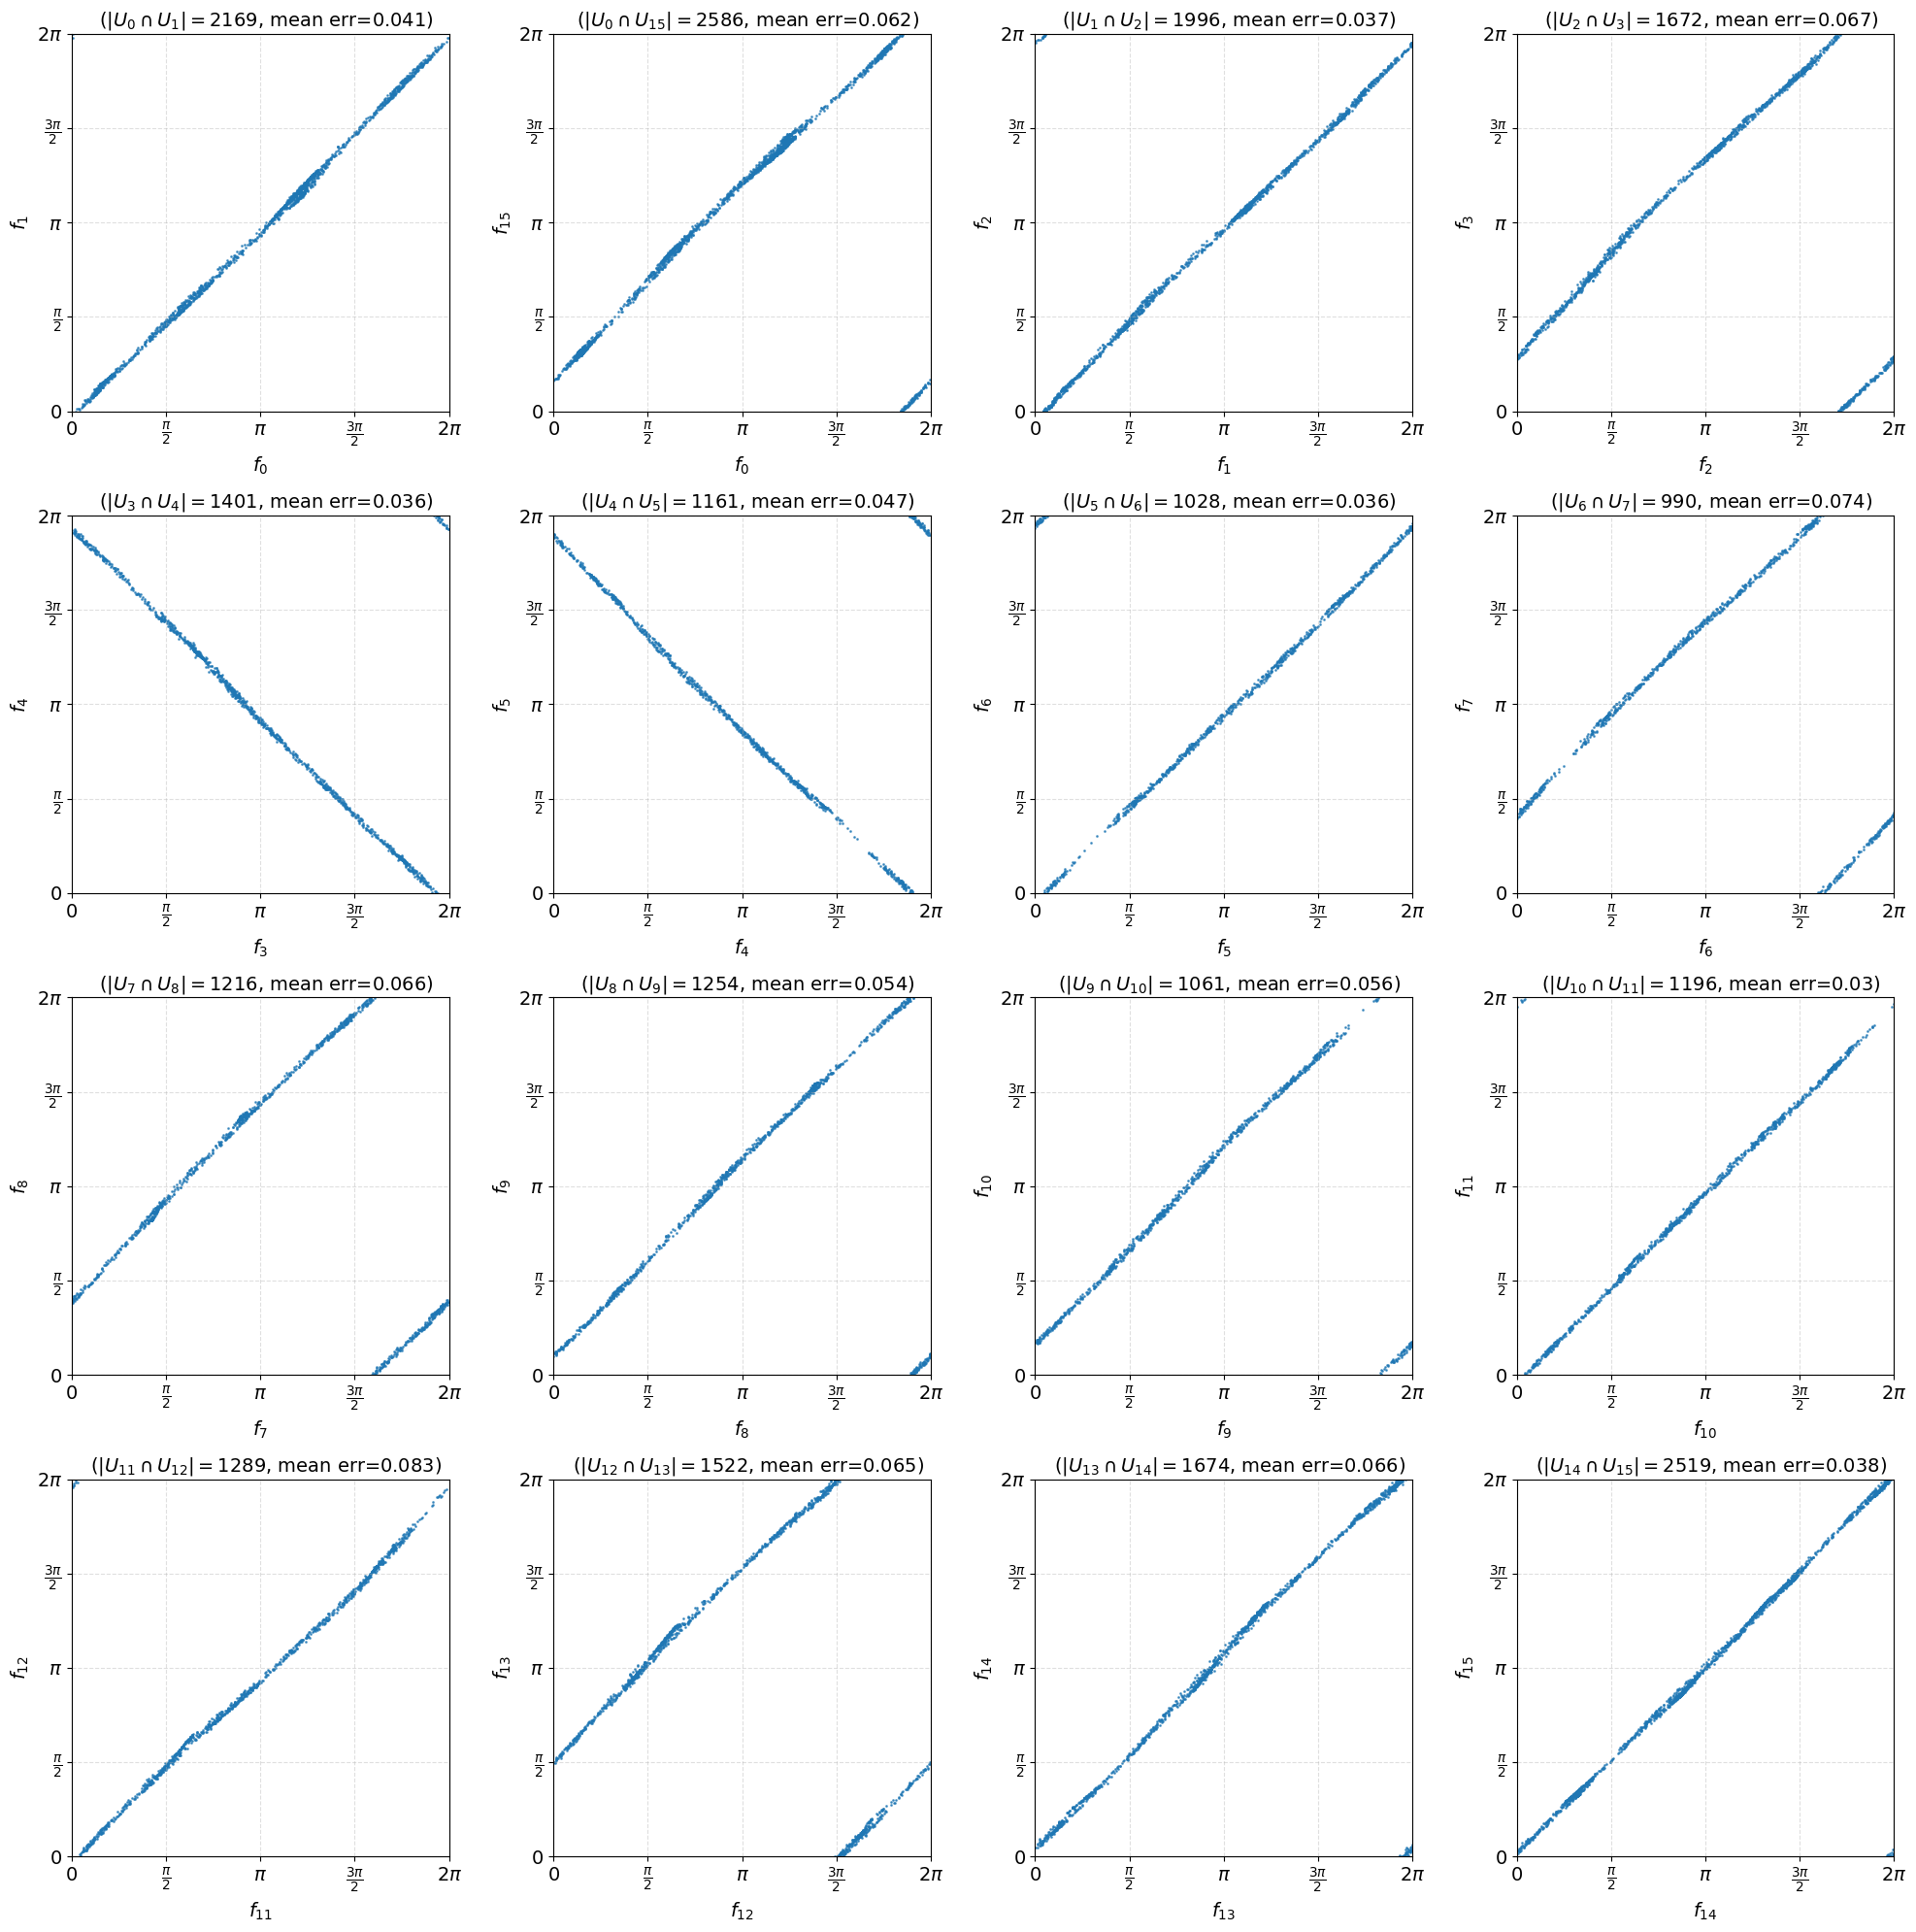

In [8]:
fig = bundle.compare_trivs(ncols = 4)
plt.show()

Since the global structure is trivial, synchronize local circular coordinates to construct a toroidal coordinate system for the dataset: 

In [9]:
fiber_angles = bundle.get_global_trivialization()

Now, view a sample of high-directionality patches arranged by toroidal coordinates:

16076 high-directionality patches


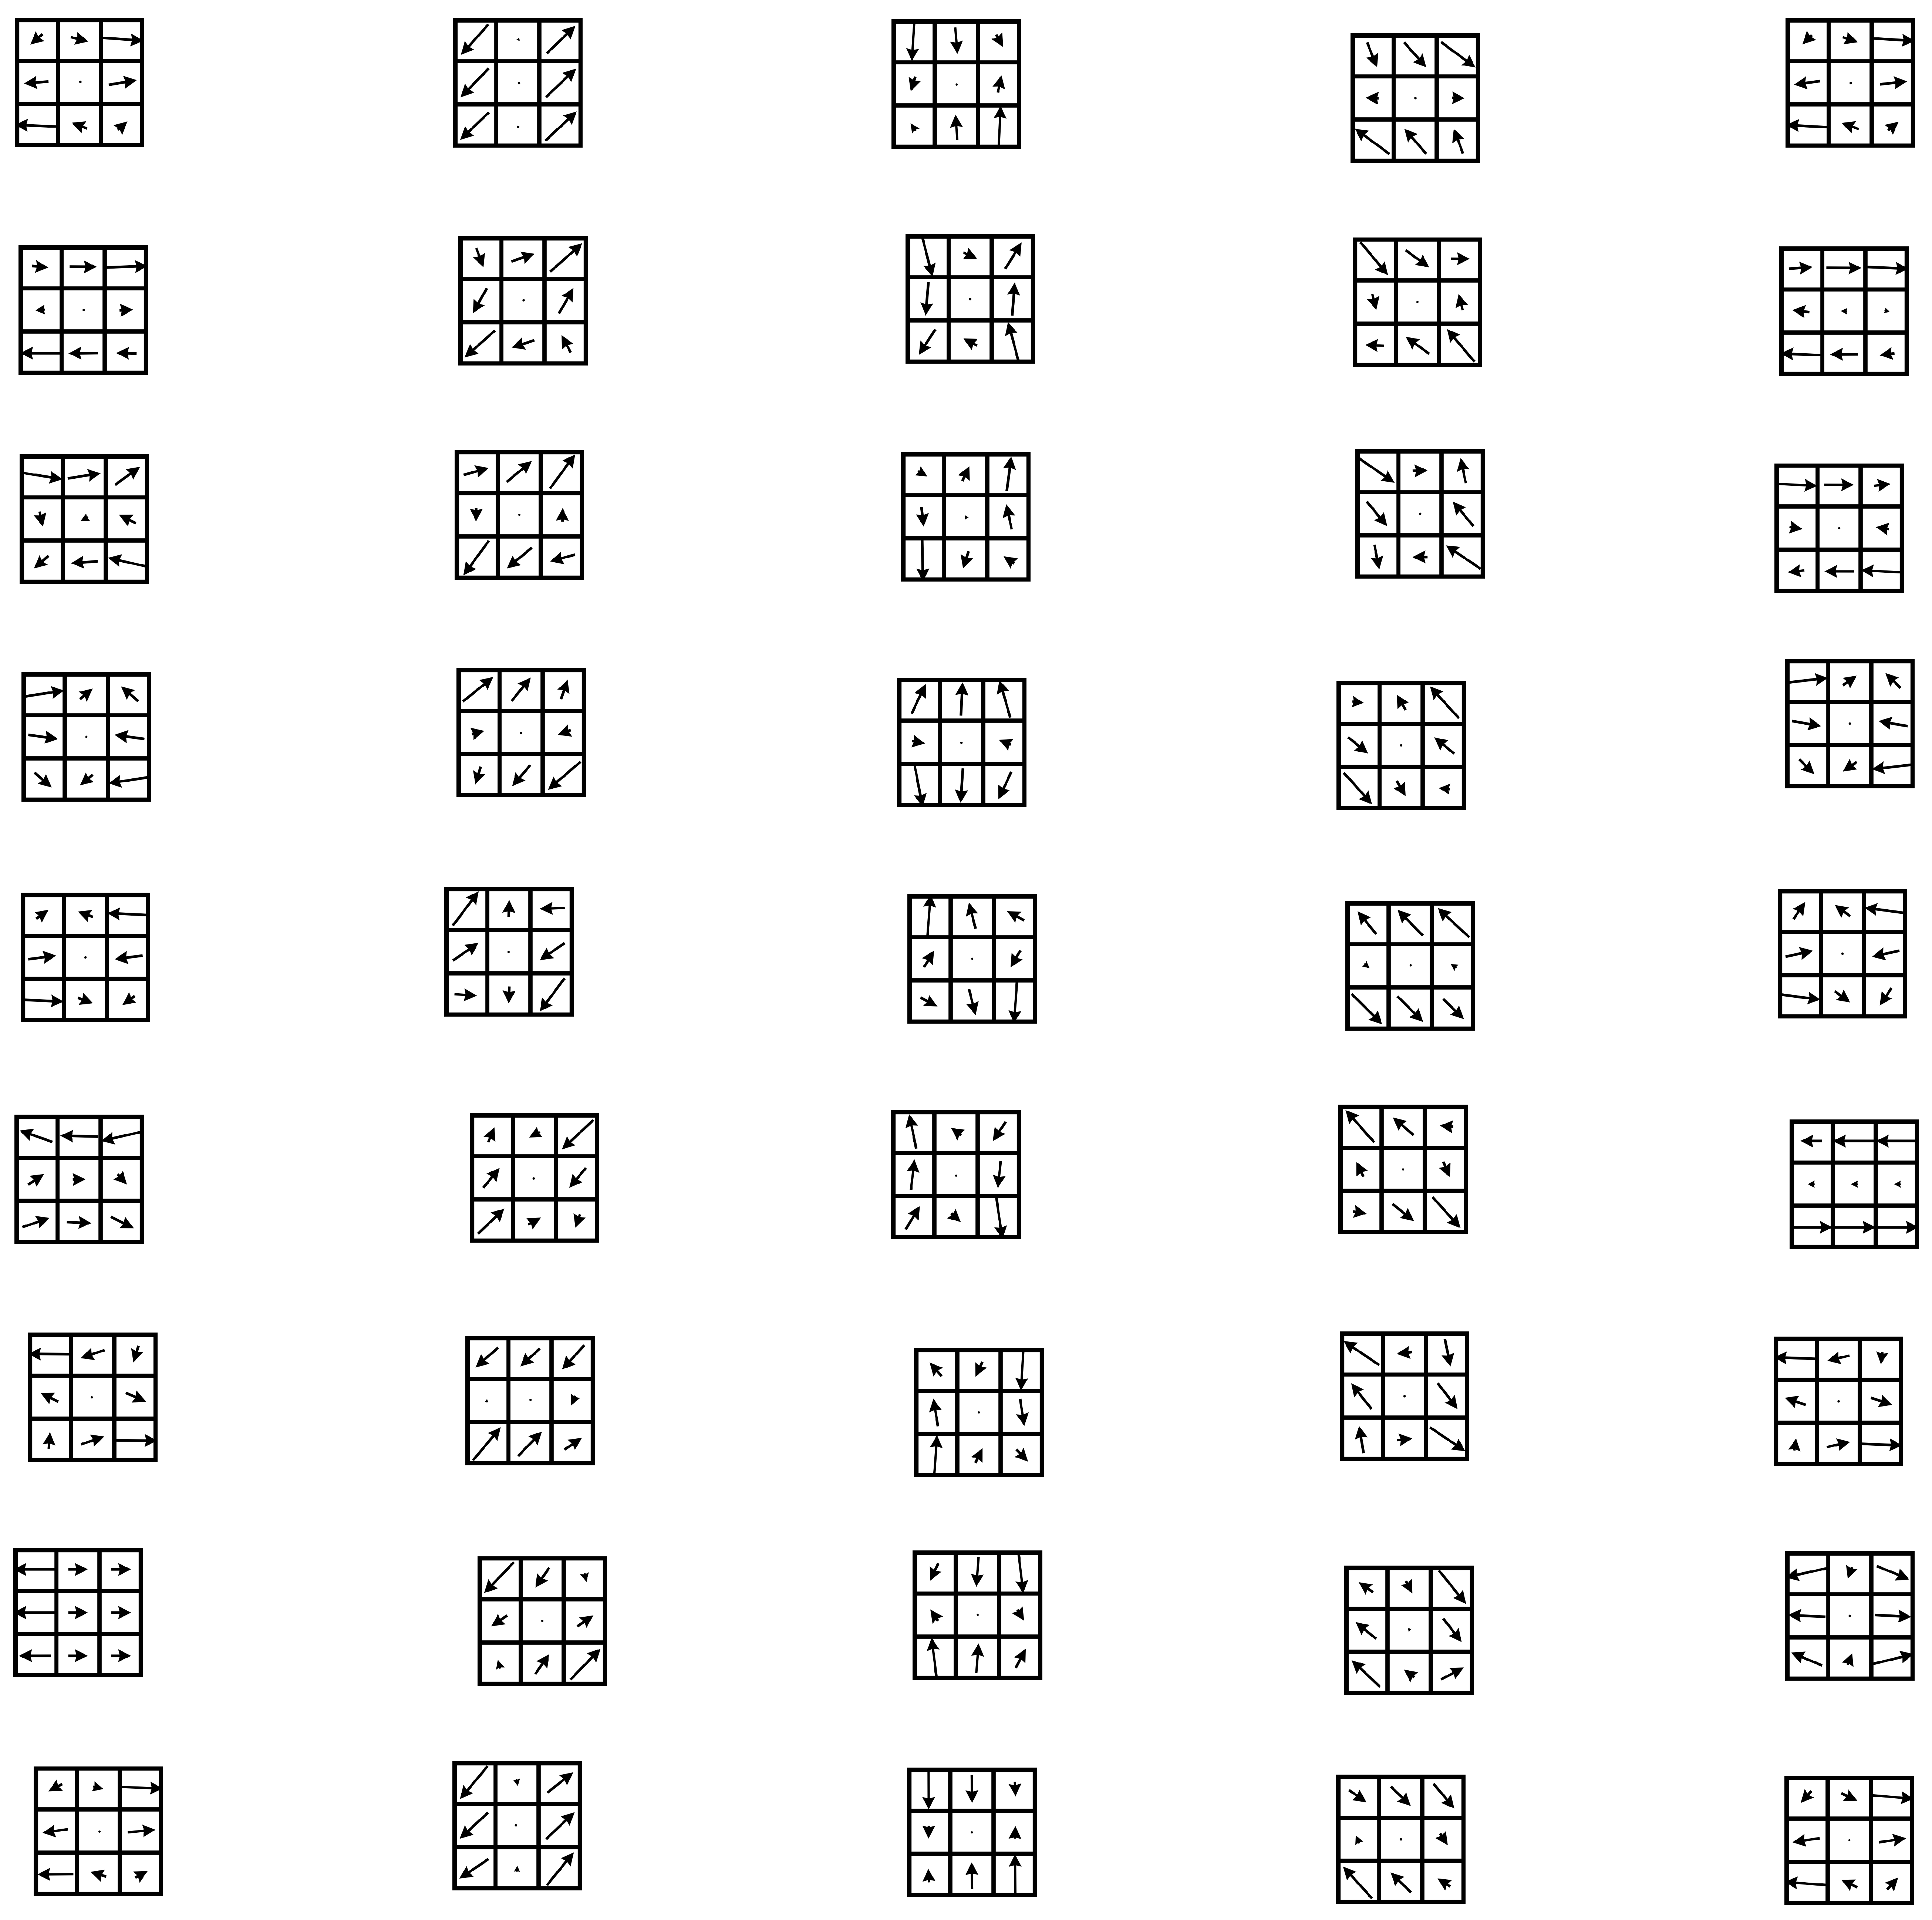

In [10]:
thresh = 0.8
high_inds = ratios > thresh
print(f'{np.sum(high_inds)} high-directionality patches')
high_data = data[high_inds]


per_row = 5
per_col = 9
coords = np.array([predom_dirs[high_inds], fiber_angles[high_inds]]).T

fig = cb.lattice_vis(
    high_data,
    coords,
    patch_vis,
    per_row=per_row,
    per_col = per_col,
    figsize=19,
    thumb_px=350,   
    dpi=350,
    padding = 0
)

plt.show()



View a sample of low-directionality patches arranged by toroidal coordinates:

5314 low-directionality patches


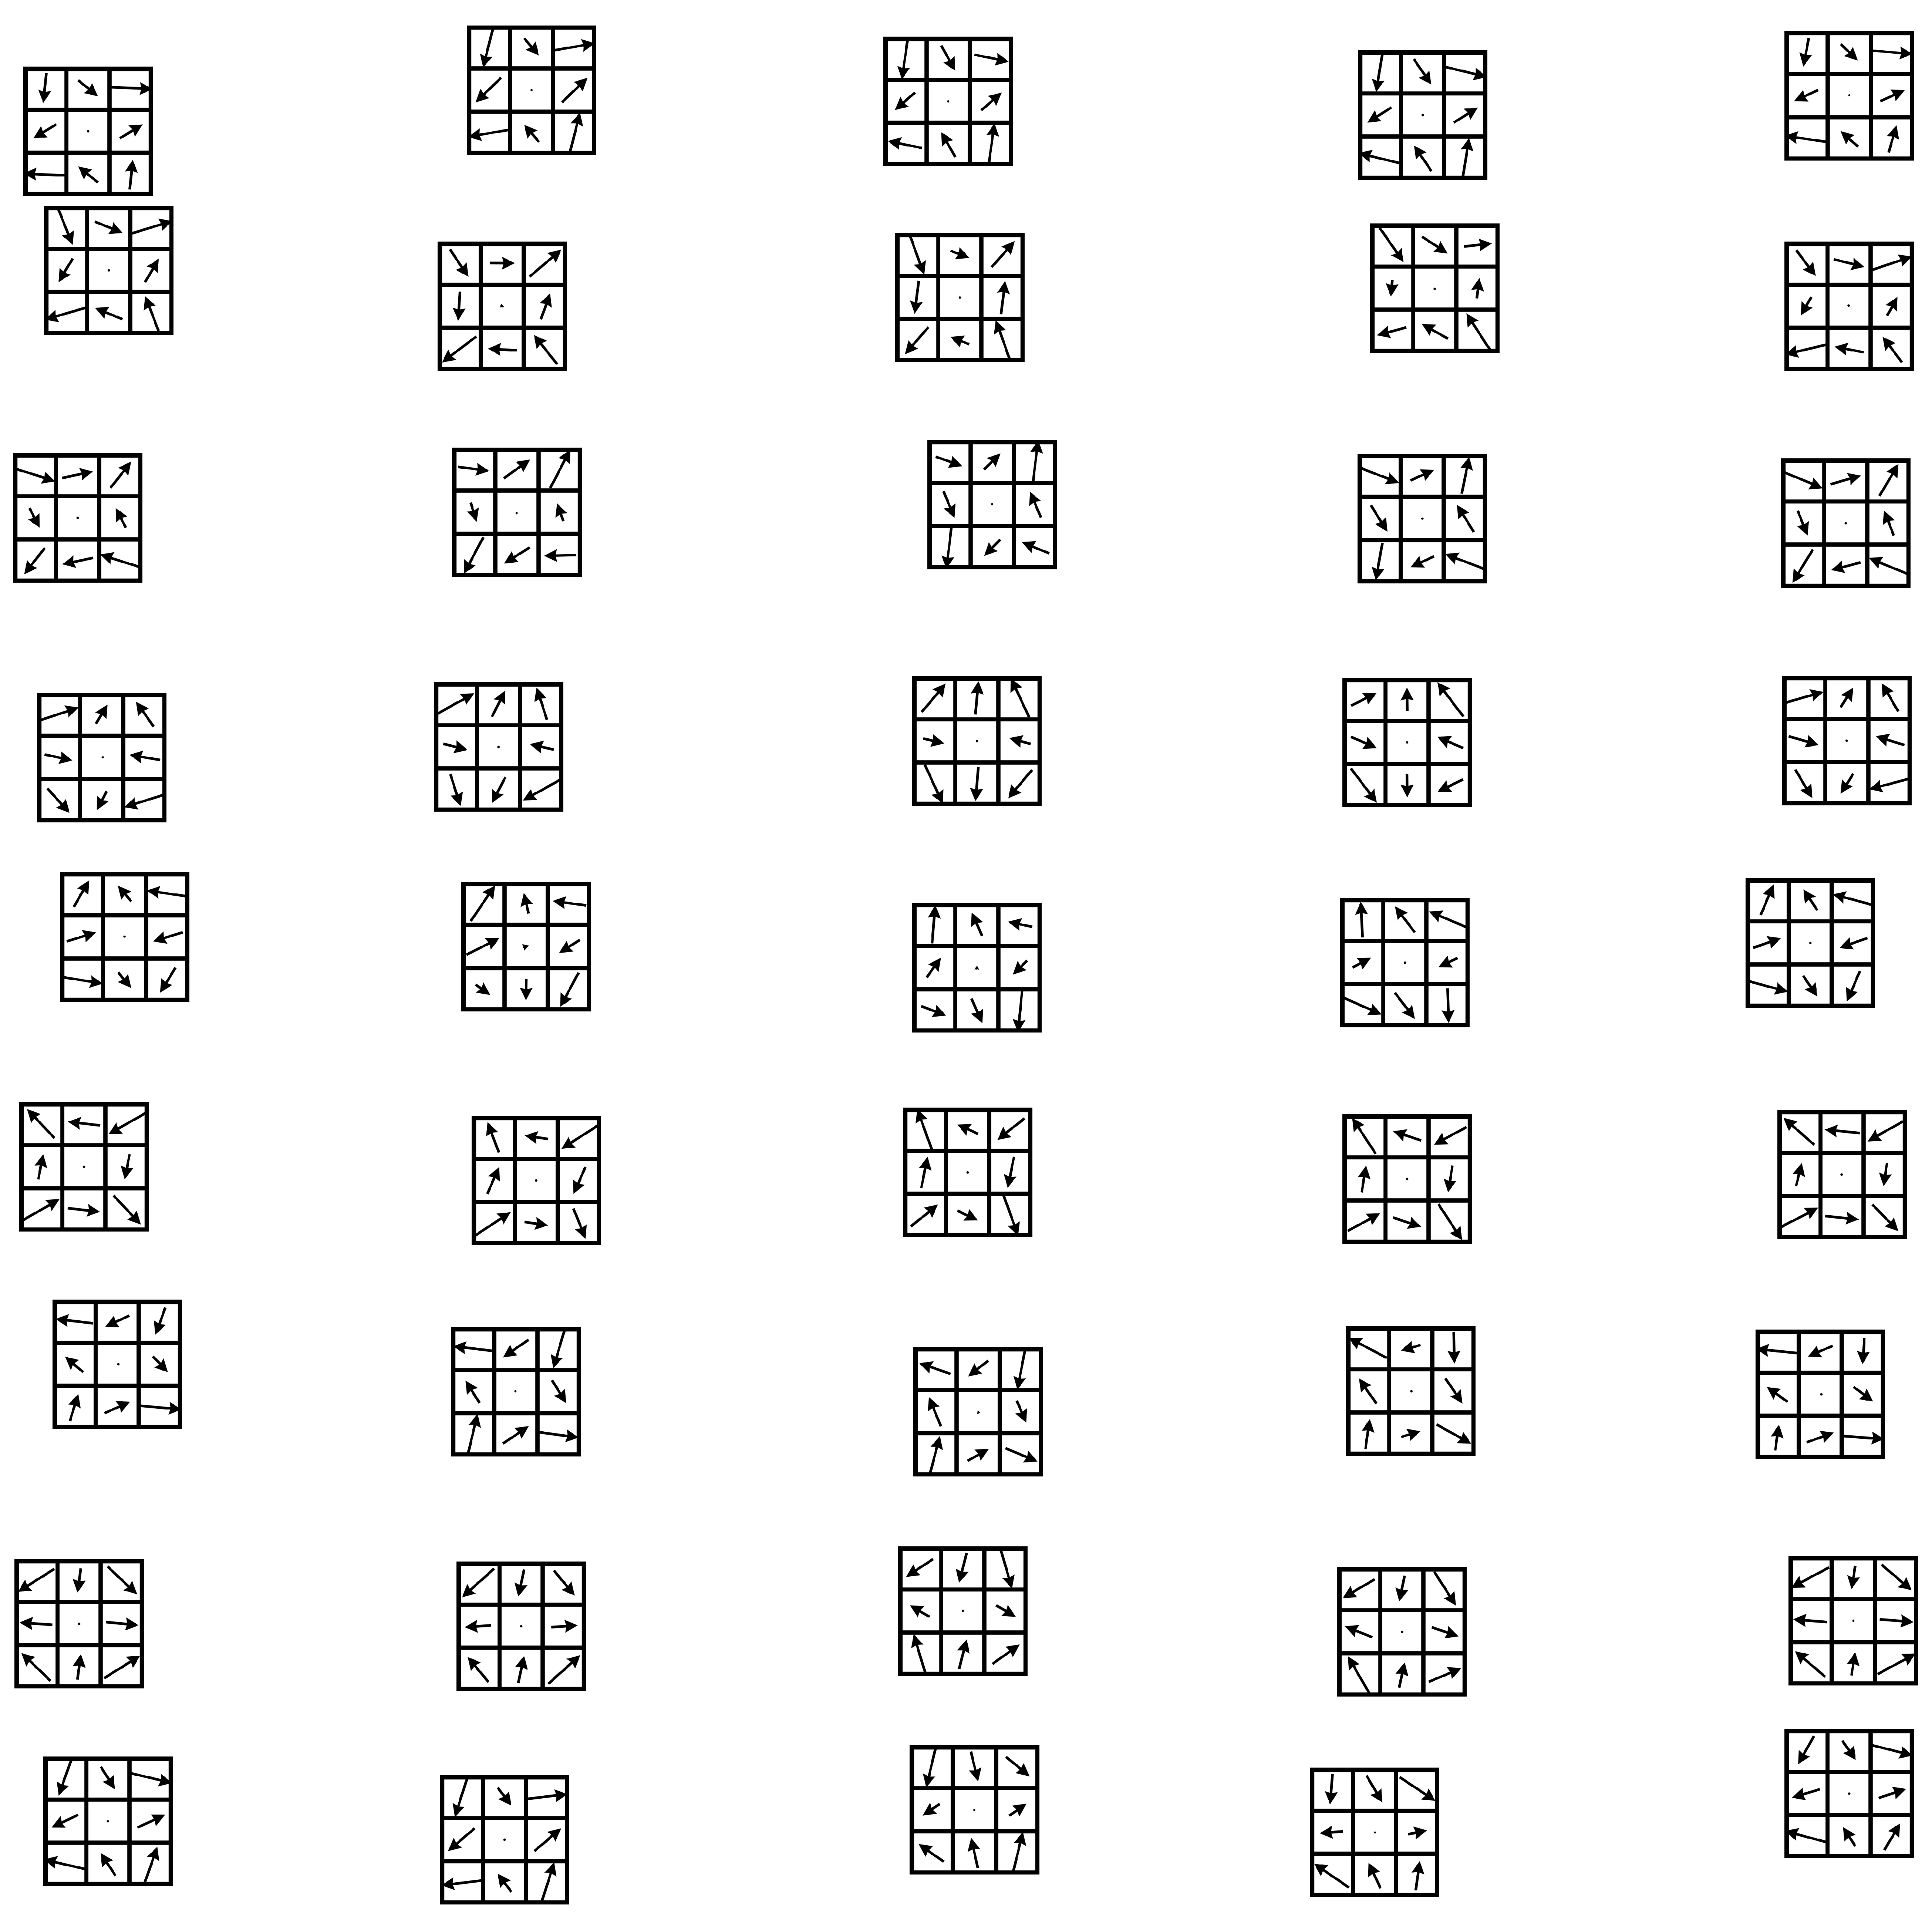

In [12]:
thresh = 0.7
low_inds = ratios < thresh
print(f'{np.sum(low_inds)} low-directionality patches')
low_data = data[low_inds]


per_row = 5
per_col = 9
coords = np.array([predom_dirs[low_inds], fiber_angles[low_inds]]).T

fig = cb.lattice_vis(
    low_data,
    coords,
    patch_vis,
    per_row=per_row,
    per_col = per_col,
    figsize=19,
    thumb_px=350,   
    dpi=350,
    padding = 0
)

plt.show()



Observe that every column is nearly identical: this reflects the fact that the low-directionality data is concentrated near a single circle at the center of the thickened torus structure. 